In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
pd.set_option('future.no_silent_downcasting', True)

from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"..\..\Datasets\India\Dynata"

# DATA WRANGLING

In [3]:
df00 = pd.read_csv(rf"{import_folder_path}/Indian Risk Literacy DYNATA_280525.csv")[26:]
df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]] = df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]].astype(float)
df00["Q9b_11"] = df00["Q9b_5"] + df00["Q9b_11"]
df00["Q9b_12"] = df00["Q9b_6"] + df00["Q9b_12"]
df00.drop(["Q9b_5", "Q9b_6"], axis = 1, inplace = True)

df00.rename({"ResponseId":"responseid"}, axis = 1, inplace = True)

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["responseid"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print("Post removing students:", len(df01["responseid"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
conversion_dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(conversion_dict)

df01[ques] = pd.to_numeric(df01[ques], errors='coerce')

df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["responseid"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["responseid"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print("Post removing <0.5 median time responses:", len(df01["responseid"]))

df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "responseid", range(0, len(df0)))

Post dropping NA: 963
Post removing students: 961
Post removing straightliners: 846
Post attention chaeck failures: 846
Post removing <0.5 median time responses: 699


In [4]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b"].astype(float).copy()

In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 699

Gender:
Male      361
Female    338

Occupation:
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12

Education:
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11

ISCED:
1    252
2    241
3    206

Income:
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42


In [6]:
df0.loc[df0["Q15a"] == "INR 50,00,001 – INR 75,00,000"]["isced"].value_counts()

isced
1    26
3    16
2    10
Name: count, dtype: int64

In [7]:
df0.loc[df0["Q15a"] == "> INR 75,00,000"]["isced"].value_counts()

isced
1    25
3    11
2     6
Name: count, dtype: int64

## Winsorizing Wealth: No winsorizing happening yet, look for top values, and their frequency

In [8]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

def winsorize_output(sample, variable, limits = [0, 0]):
    sample[f"nonwinsorised_{variable}"] = sample[variable]
    sample[f"winsorised_{variable}"] = winsorize(np.array(sample[f"nonwinsorised_{variable}"]), limits = limits, inclusive = [False, False])
    sample[[f"nonwinsorised_{variable}", f"winsorised_{variable}"]].describe()
    print(sample[[f"winsorised_{variable}", f"nonwinsorised_{variable}"]].describe())
    print("\n\nTop values and their count: ", (sample[f"nonwinsorised_{variable}"].value_counts().sort_index().tail(n=10)))
    print("\n\n")
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    sns.kdeplot(data = sample[f"nonwinsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
    axes[0].set_title(f'Nonwinsorised {variable}')
    sns.kdeplot(data = sample[f"winsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
    axes[1].set_title(f'Winsorized {variable}')
    plt.tight_layout()
    plt.show()

    sample[variable] = sample[f"winsorised_{variable}"]
    return sample[variable]

       winsorised_wealth  nonwinsorised_wealth
count       6.990000e+02          6.990000e+02
mean        1.628566e+08          1.628566e+08
std         3.794346e+09          3.794346e+09
min         0.000000e+00          0.000000e+00
25%         1.000000e+05          1.000000e+05
50%         6.000000e+05          6.000000e+05
75%         4.000000e+06          4.000000e+06
max         1.000000e+11          1.000000e+11


Top values and their count:  nonwinsorised_wealth
9.000000e+07    1
1.000000e+08    3
1.100000e+08    1
1.500000e+08    2
1.565000e+08    1
2.000000e+08    1
3.000000e+08    1
1.000000e+09    1
8.144789e+09    1
1.000000e+11    1
Name: count, dtype: int64





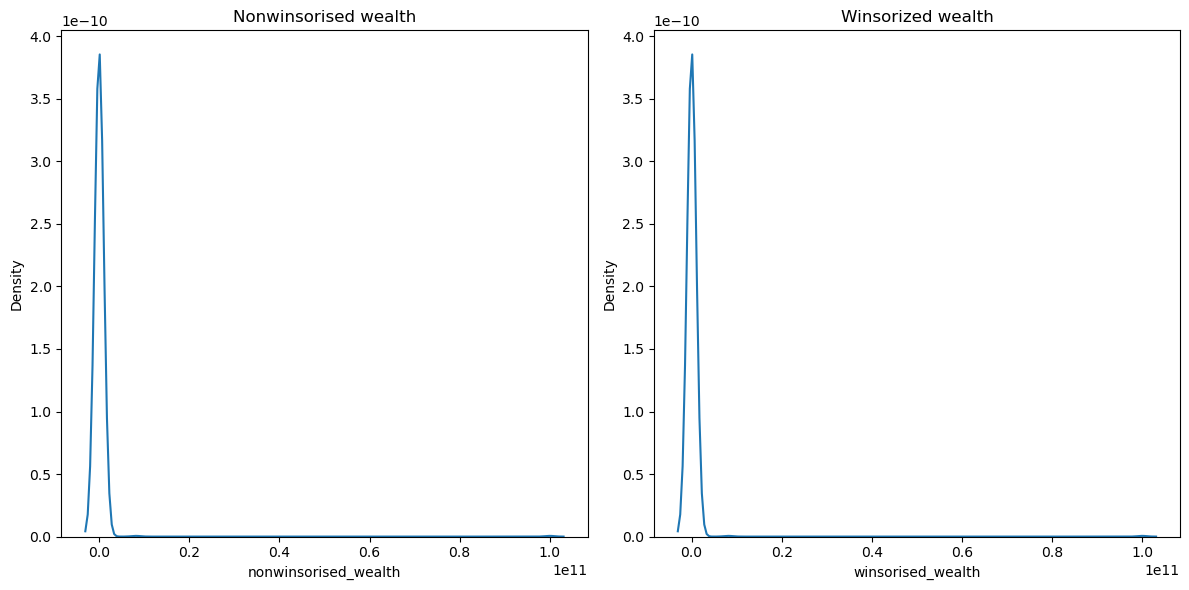

In [9]:
winsorized_wealth = winsorize_output(df0, "wealth", [0, 0])

In [10]:
# Using winsorised wealth as wealth
df0["wealth"] = winsorized_wealth

## Questions

In [11]:
df0.columns

Index(['responseid', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_11', 'Q9b_12', 'Q9b_7',
       'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b', 'Q11a_1', 'Q11a_2',
       'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4', 'Q11b_5', 'Q11c',
       'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a', 'Q13b', 'Q13c',
       'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1', 'Q14c', 'Q54', 'Q57',
       'Q58', 'Q15a', 'psid', 'entrySigCheck', 'verification', 'age',
       'age_rec', 'isced', 'income', 'wealth', 'nonwinsorised_wealth',
       'winsorised_wealth'],
      dtype='object')

In [12]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [13]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [14]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [15]:
# Dynata Only

further_analysis_cols = [
    "Q5_1", "Q6 - changed",
    "Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8",
    "Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12",
    "Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14",
    "Q12a", "Q12b", "Q12c"
    ] # not used


df0["Q5_1"] = df0["Q5_1"].astype(str)
df0["Q5_score"] = np.where(df0["Q5_1"] == "0 (unwilling to take risk)", 0,
                           np.where(df0["Q5_1"] == "1", 1,
                                    np.where(df0["Q5_1"] == "2", 2,
                                             np.where(df0["Q5_1"] == "3", 3,
                                                  np.where(df0["Q5_1"] == "4", 4,
                                                           np.where(df0["Q5_1"] == "5", 5,
                                                                    np.where(df0["Q5_1"] == "6", 6,
                                                                             np.where(df0["Q5_1"] == "7 (willing to take risk)", 7, -1
                                                                                      )
                                                                             )
                                                                    )
                                                           )
                                                      )
                                             )
                                    )
                           )

df0["Q6 - changed"] = df0["Q6 - changed"].astype(str)
df0["Q6_score"] = np.where(df0["Q6 - changed"] == "Definitely no experience", 0,
                           np.where(df0["Q6 - changed"] == "Rather little experience", 1,
                                        np.where(df0["Q6 - changed"] == "Some experience", 2,
                                                 np.where(df0["Q6 - changed"] == "Rather much experience", 3,
                                                          np.where(df0["Q6 - changed"] == "Definitely very much experience", 4, -1
                                                                   )
                                                          )
                                                 )
                                        )
                           )

cols = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
df0[cols] = df0[cols].astype(int)
df0["Q8_total"] = df0[cols].sum(axis = 1)

cols = ["Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12"]
df0[cols] = df0[cols].astype(float)
df0["Q9_safe_total"] = df0[cols].sum(axis = 1)

cols = ["Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14"]
df0[cols] = df0[cols].astype(float)
df0["Q9_risky_total"] = df0[cols].sum(axis = 1)

cols = ["Q12a", "Q12b", "Q12c"]
df0[cols] = df0[cols].astype("string")

df0["Q12a_score"] = np.where(df0["Q12a"] == "More than INR 102", 1, 0)
df0["Q12b_score"] = np.where(df0["Q12b"] == "Less than today with the money in this account", 1, 0)
df0["Q12c_score"] = np.where(df0["Q12c"] == "False", 1, 0)

cols = ["Q12a_score", "Q12b_score", "Q12c_score"]
df0["Q12_total"] = df0[cols].sum(axis = 1)

In [16]:
df0["Q12c"].value_counts()

Q12c
False               355
True                261
Do not know          79
Refuse to answer      4
Name: count, dtype: Int64

## SCORING

In [17]:
focal_col = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5",
             "q8_3", "q8_4",
             "q8_5berlin_1", "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7",
             "q9_1_1", "q9_2_1", "q9_3",
             "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]

for col in focal_col:
    df0[col] = df0[col].astype(float)

scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
"uncertainty1", "uncertainty2",
"numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
"graph1", "graph2", "graph3",
"riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
"bayesian1"
]

# Dynata Only
req_cols = [
    "riskappetite1", "riskappetite2","financialhabits",
    "riskyassets_%", "safeassets_%",
    "financialliteracy"]

df0[scoreColumns + req_cols] = 0

In [18]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Dynata Only
    surveyFacet.loc[:, "riskappetite1"] = surveyFacet["Q5_score"]
    surveyFacet.loc[:, "riskappetite2"] = surveyFacet["Q6_score"]
    
    surveyFacet.loc[:, "financialhabits"] = surveyFacet["Q8_total"]

    surveyFacet.loc[:, "riskyassets_%"] = surveyFacet["Q9_risky_total"]
    surveyFacet.loc[:, "safeassets_%"] = surveyFacet["Q9_safe_total"]
    
    surveyFacet.loc[:, "financialliteracy"] = surveyFacet["Q12_total"]

    
    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [19]:
df1 = df0.groupby(["responseid"]).progress_apply(scoring1)
df1 = df1.reset_index(drop = True).copy()

100%|██████████████████████████████████████████████████████████████████████████████▊| 697/699 [00:07<00:00, 112.04it/s]C:\Users\SHIVAM\anaconda3\Lib\site-packages\tqdm\std.py:805: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 699/699 [00:07<00:00, 88.98it/s]


In [20]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100

    #Dynata Only
    survey["RiskAppetite1_7"] = survey["riskappetite1"]
    survey["RiskAppetite2_4"] = survey["riskappetite2"]
    
    survey["FinancialHabits_48"] = survey["Q8_total"]

    survey["RiskAssets_%"] = survey["Q9_risky_total"]
    survey["SafeAssets_%"] = survey["Q9_safe_total"]
    
    survey["FinancialLiteracy_3"] = survey["Q12_total"]

    survey["RiskAppetite1_%"] = survey["RiskAppetite1_7"] / 7 * 100
    survey["RiskAppetite2_%"] = survey["RiskAppetite2_4"] / 4 * 100
    survey["FinancialHabits_%"] = survey["FinancialHabits_48"] / 48 * 100
    survey["FinancialLiteracy_%"] = survey["FinancialLiteracy_3"] / 3 * 100
    
    
    colReq = [
        "responseid", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
        "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
        "TotalScore_19", "TotalScore_%",
        #Dynata only
        "RiskAssets_%", "SafeAssets_%",
        "RiskAppetite1_%", "RiskAppetite1_7", "RiskAppetite2_%", "RiskAppetite2_4",
        "FinancialHabits_%", "FinancialHabits_48",
        "FinancialLiteracy_%", "FinancialLiteracy_3"
    ]
    
    survey1 = survey[colReq].copy()
    return survey1

In [21]:
df2 = scoring2(df1)

In [22]:
main = df2.copy()

In [23]:
# will be used later
wealth_quartile = pd.qcut(main.loc[~ (main["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" )

## Income Terciles and Quartiles

How to Form Terciles from Categorical Data
If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
5. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.

In [24]:
main["income"].value_counts().sort_index() / len(main) * 100

income
1    27.753934
2    31.616595
3    16.309013
4    10.872675
5     7.439199
6     6.008584
Name: count, dtype: float64

### Income Terciles
1 - income = 1 --> 194 (194)

2 - income = 2 3 --> 335 (114 + 221)

3 - income = 4 5 6 --> 170 (76 + 52 + 42)

In [25]:
main["income_tercile"] = np.where(main["income"] == 1, 1,
                                  np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 2,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 3,
                                                                      np.where(main["income"] == 6, 3, -1
                                                                              )
                                                                     )
                                                            )
                                                   )
                                          )
                                 )                                  

### Income Quartiles
1 - income = 1 --> 27.7 (27.7)

2 - income = 2 --> 31.6 (31.6)

3 - income = 3 4 --> 27.1 (16.3 + 10.8)

4 - income = 5 6 --> 13.4 (7.4 + 6.0)

In [26]:
main["income_quartile"] = np.where(main["income"] == 1, 1,
                                   np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 3,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 4,
                                                                      np.where(main["income"] == 6, 4, -1
                                                                               )
                                                                      )
                                                             )
                                                    )
                                           )
                                   )   

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

In [27]:
#Global Vras:
facet_cols = ["Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - India Dynata

## Table 1.1 - Mean Total Score + SD

Text(0, 0.5, 'Mean Total score')

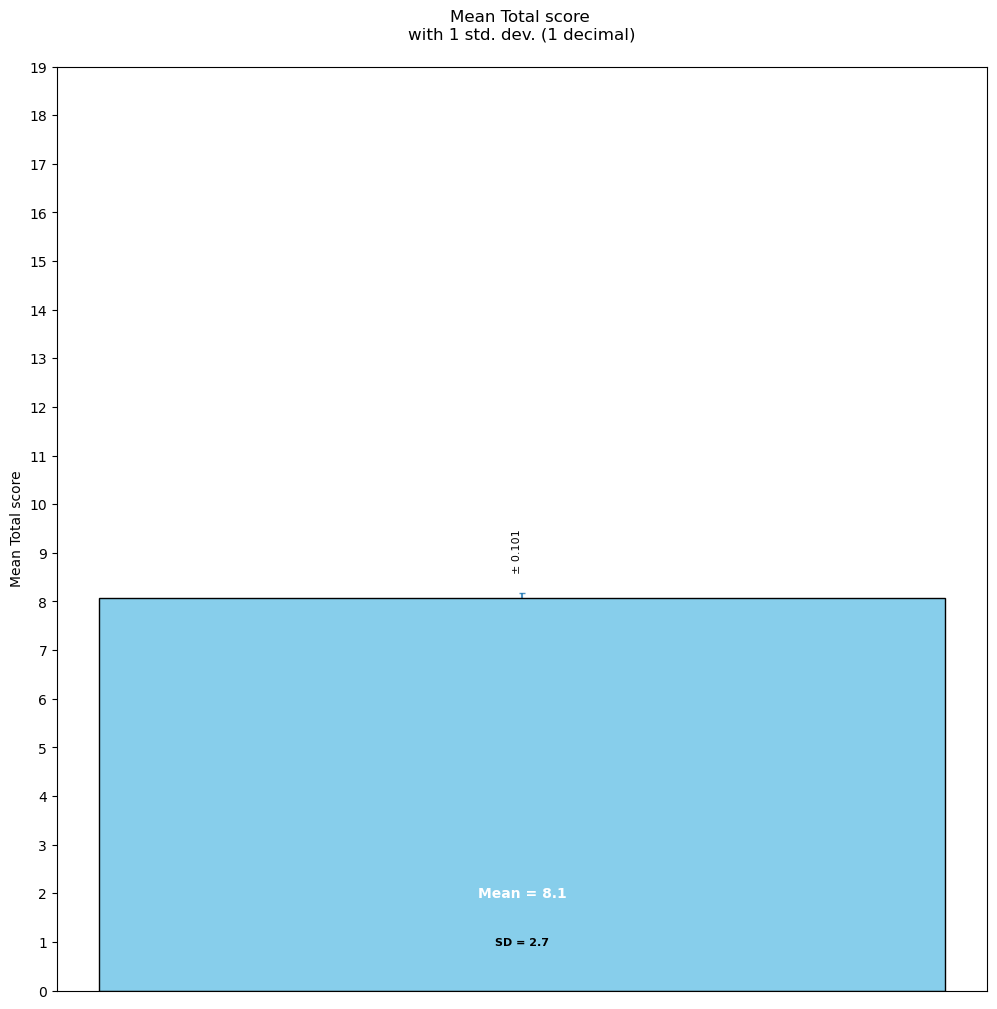

In [28]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_19"].mean()
std = main["TotalScore_19"].std()
sem = main["TotalScore_19"].sem()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 20))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)


axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 1, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score \nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

----------------------------------

## Table 1.2 - Mean Facet Scores + SD (Ver. 1)

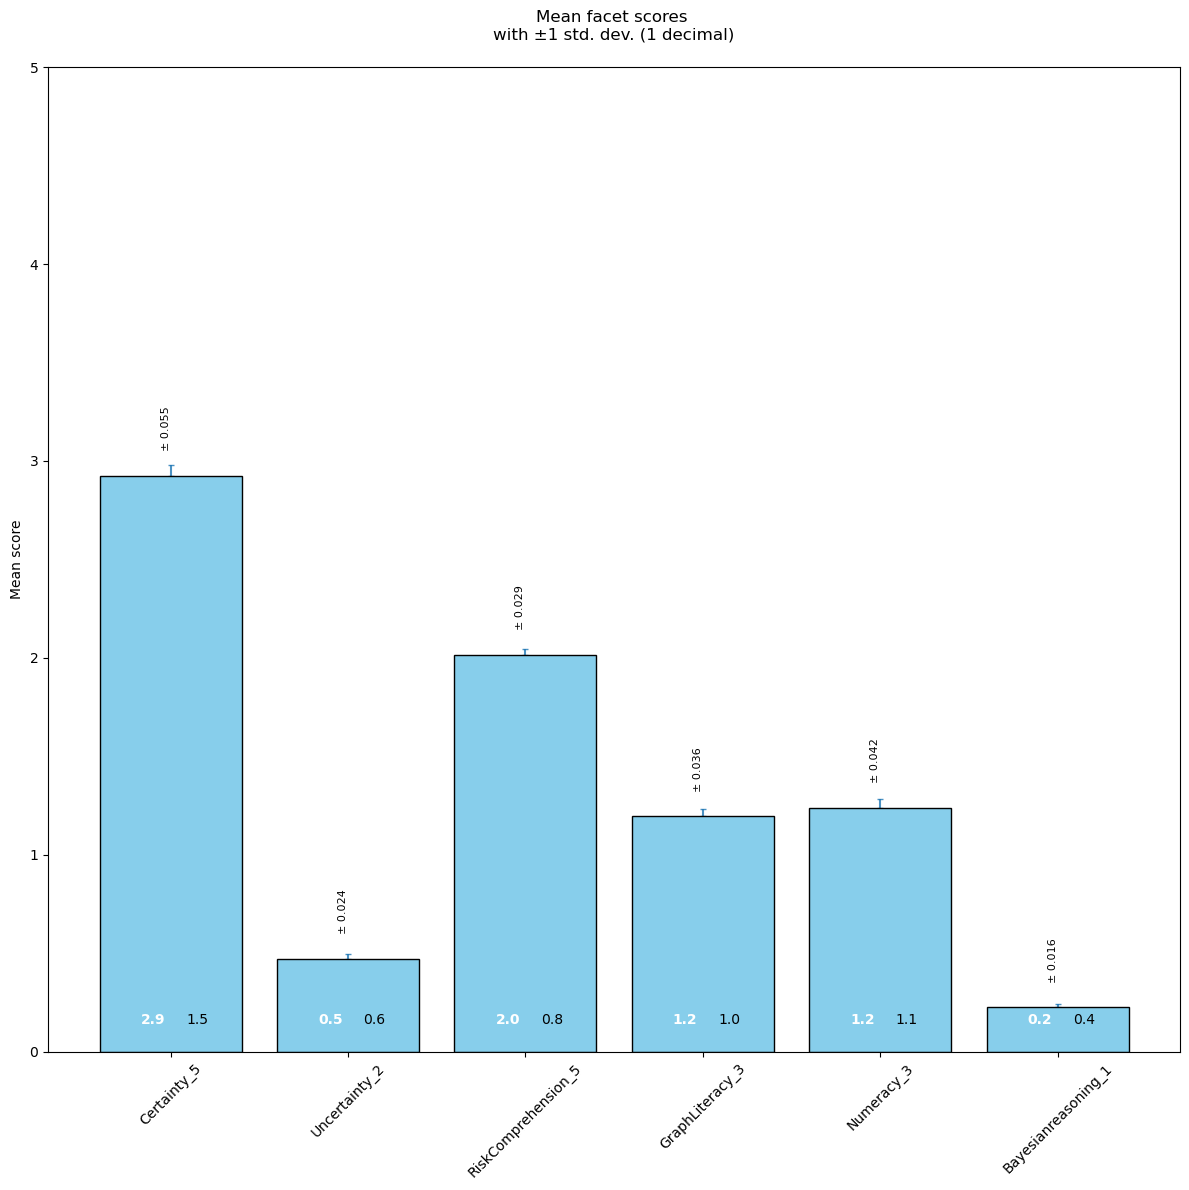

In [29]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_cols].mean()
std_scores = main[facet_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_cols].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 5
axes.set_yticks(np.arange(0, y_max + 1))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j - 0.1, 0.025 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j + 0.15, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10)

    

axes.set_title(f"Mean facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean score")


plt.tight_layout()
plt.show()

---

---

## Table 1.3 - M proportion of maximum (Total Score) score + SD + Median

Text(0, 0.5, 'Mean % score')

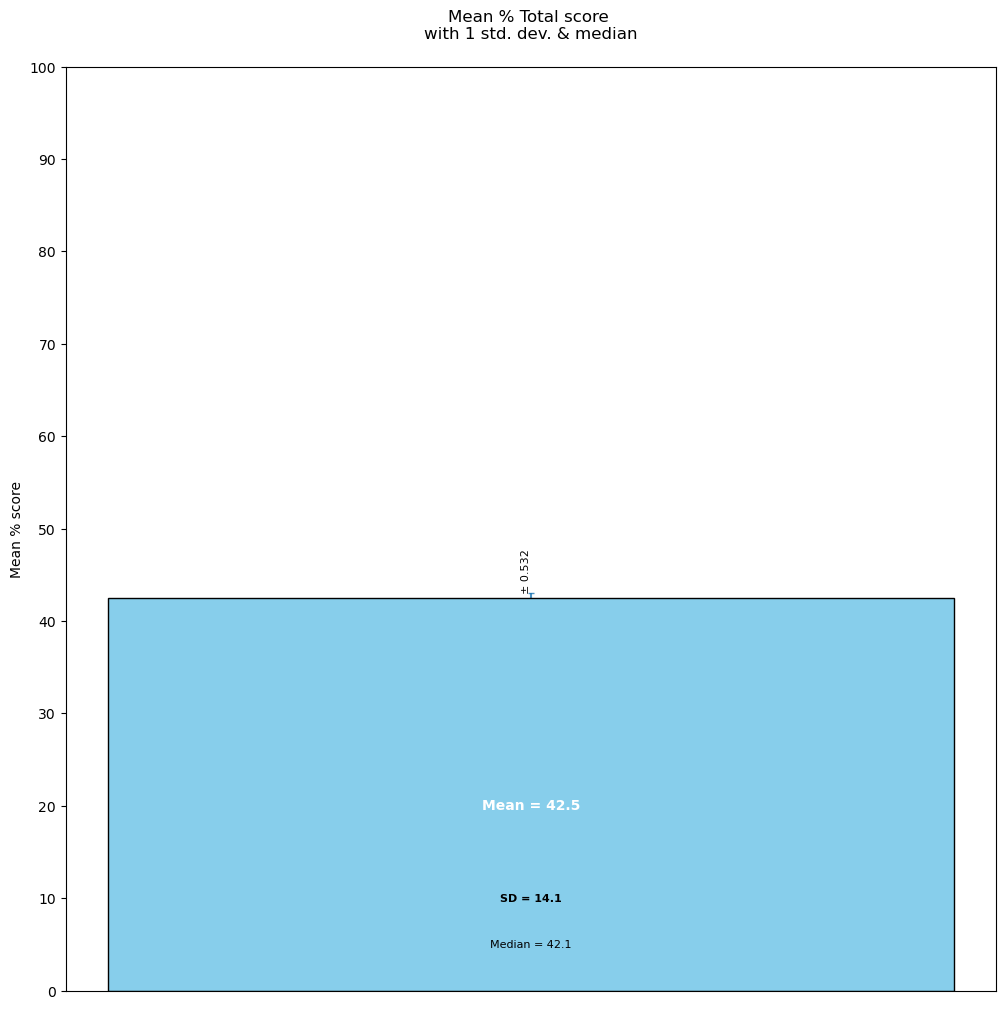

In [30]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_%"].mean()
std =  main["TotalScore_%"].std()
sem =  main["TotalScore_%"].sem()
med =  main["TotalScore_%"].median()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)

axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
axes.text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
          color='black', fontsize=8)
    

axes.set_title("Mean % Total score \nwith 1 std. dev. & median", pad = 20)
axes.set_ylabel("Mean % score")

----------------------------------

## Table 1.4 - M proportion of Facet Scores + SD + Median

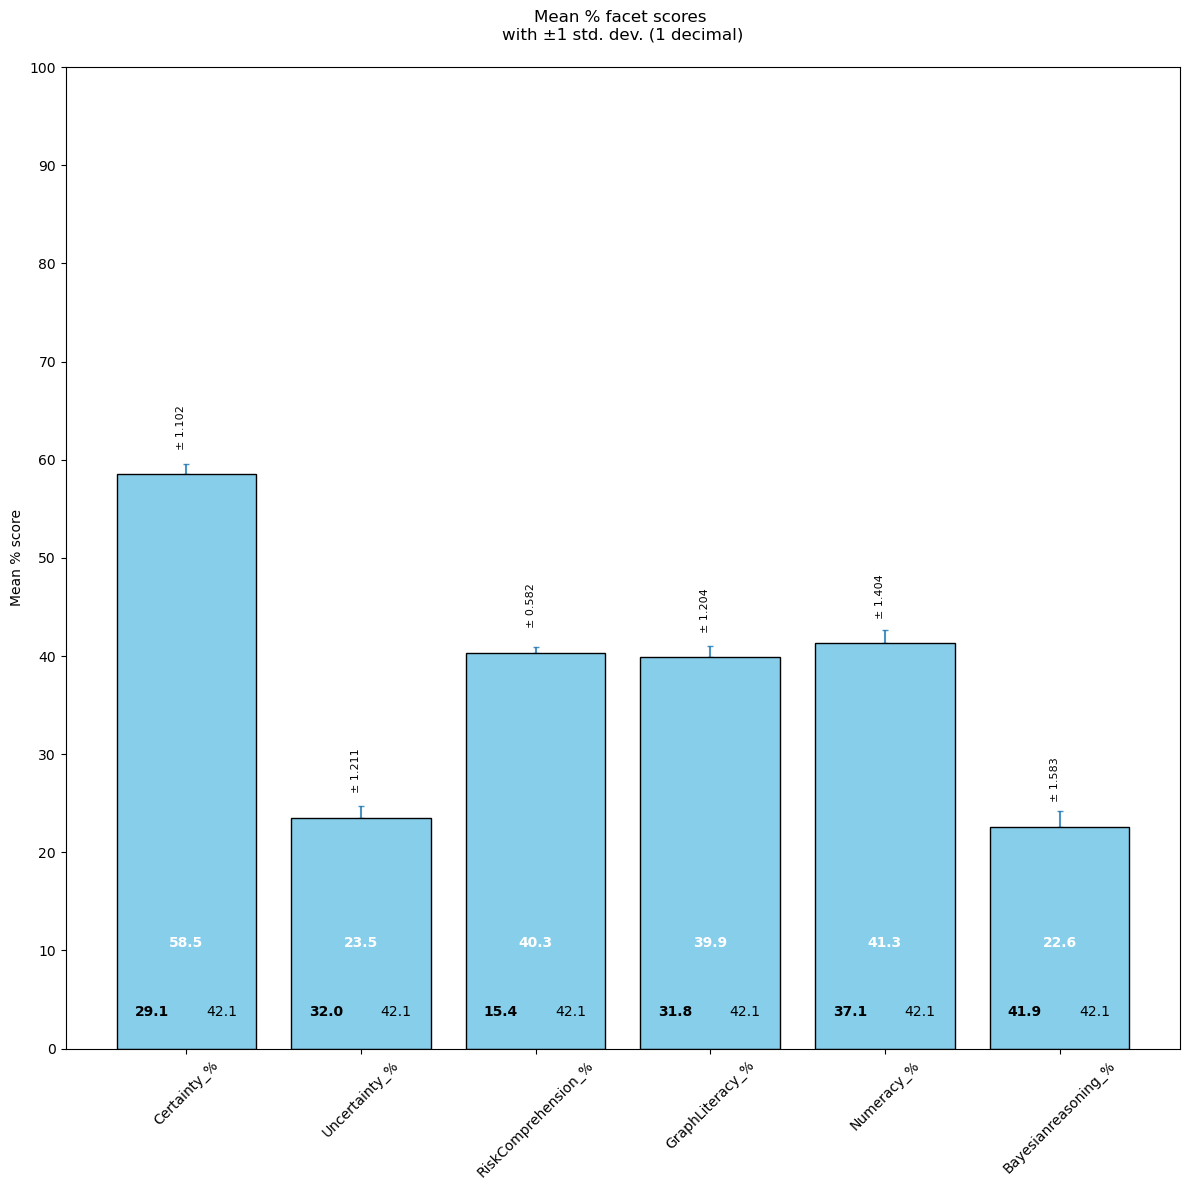

In [31]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_percent_cols].mean()
std_scores = main[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores = main[facet_percent_cols].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)

    

axes.set_title(f"Mean % facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean % score")
plt.tight_layout()
plt.show()

---

---

## Table 2.1 - Per income class: Mean Facet Scores + SD + Median

Note: Income Class has been filtered out of entries who opted out of disclosing their income

In [32]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()
income_filtered.income.value_counts()

income
2    221
1    194
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [33]:
# fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

# income_classes = income_filtered.income.value_counts().sort_index().index.values

# for i, income_class in enumerate(income_classes):
#     sample = income_filtered.loc[ income_filtered["income"] == income_class].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = [sem],
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor income class :{income_class}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

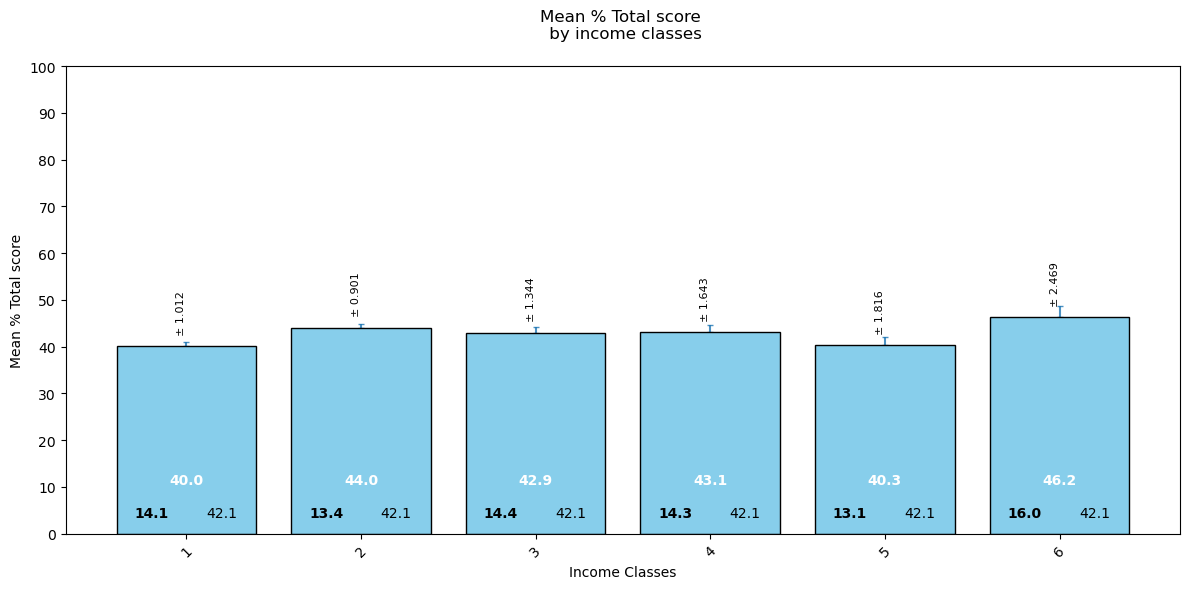

In [34]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("income")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by income classes", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Income Classes")

plt.tight_layout()
plt.show()

---

## Table 2.2 - Per income class: Mean Facet Scores

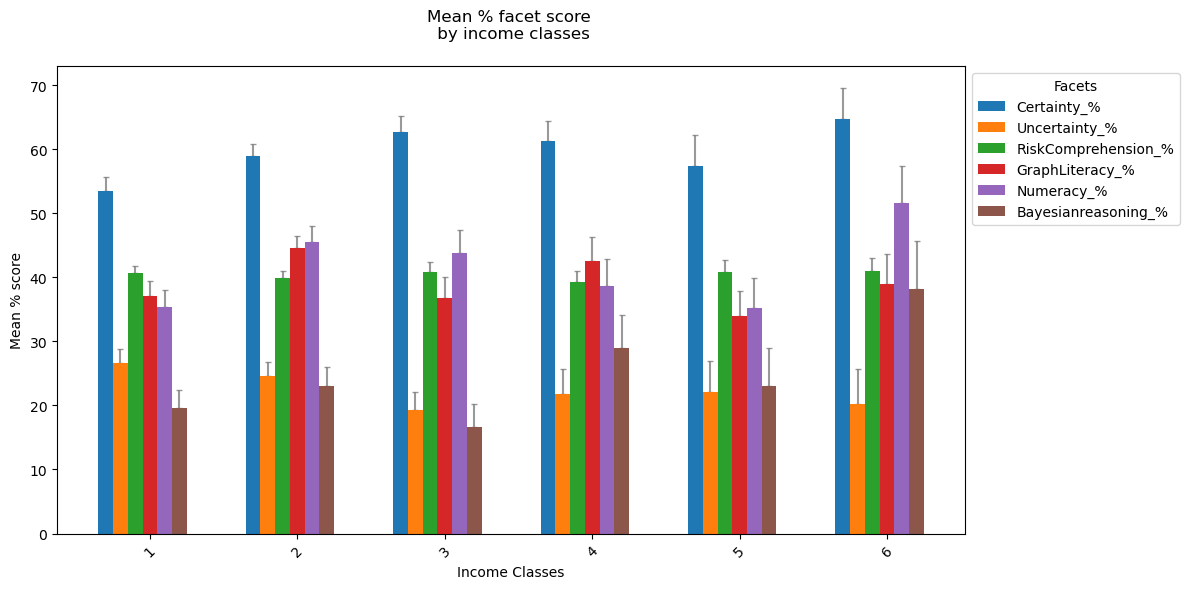

In [35]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("income")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(income_classes)/ 2 + j) * width
    axes.bar(income_classes + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(income_classes + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by income classes", pad = 20)
axes.set_ylabel("Mean % score")
axes.set_xlabel("Income Classes")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

---

## Table 3.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [36]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()

risklit_quartile = pd.qcut(income_filtered["TotalScore_19"],q = 4, labels = False ) + 1
income_filtered["risklit_quartile"] = risklit_quartile.copy()

data = income_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [37]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "income")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
# plt.show()

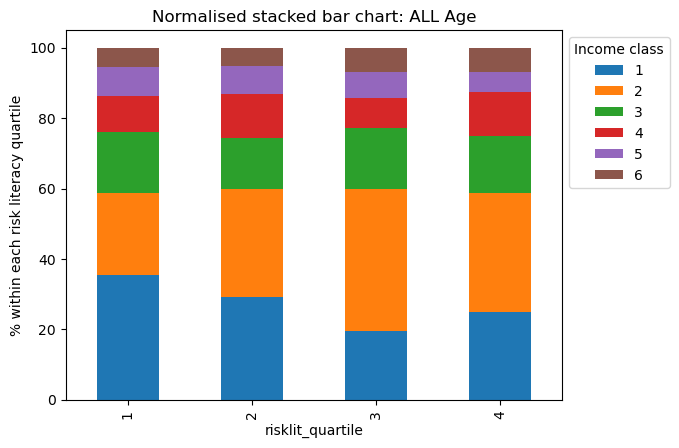

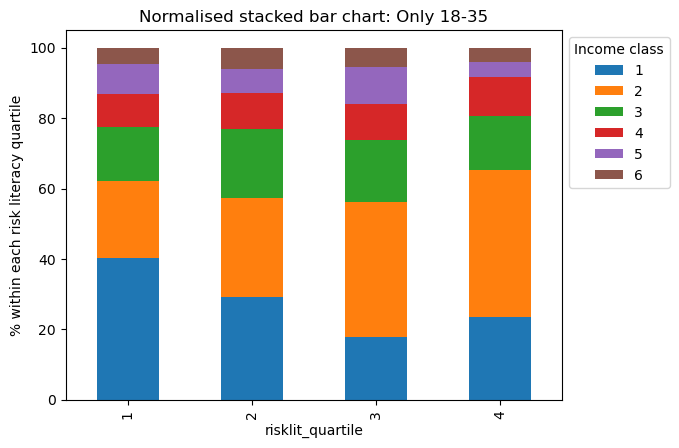

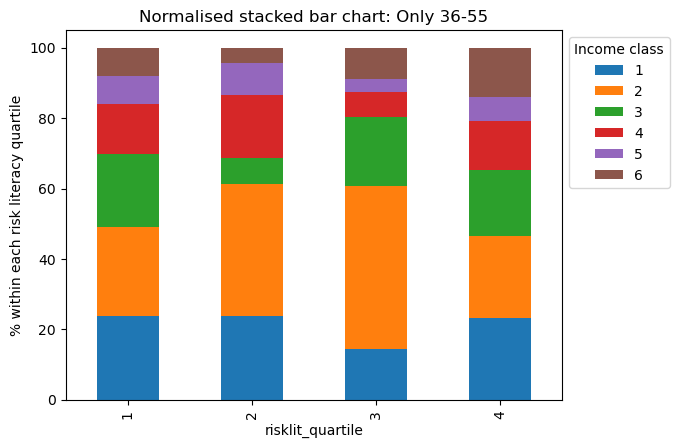

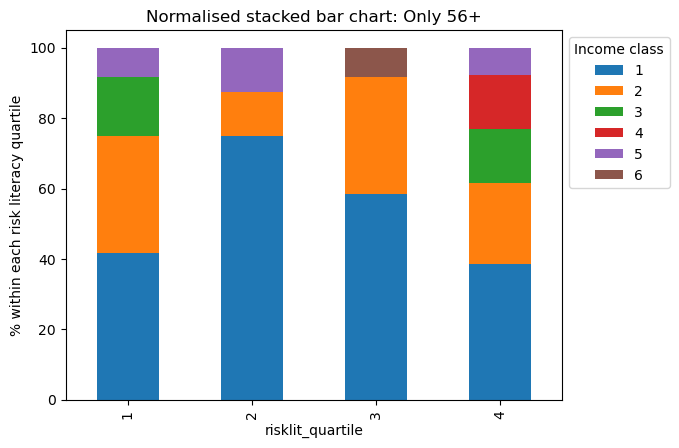

In [38]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "income")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median facet scores

Note: Wealth Class has been filtered out of entries who opted out of disclosing their income, and a quartile on the resulting data has been created

In [39]:
wealth_filtered = main.loc[ ~(pd.isnull(main["wealth"]))].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [40]:
# fig, axes = plt.subplots(4, 1, figsize = [12, 6*4])

# wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

# for i, wealth_quartile in enumerate(wealth_quartiles):
#     sample = wealth_filtered.loc[ wealth_filtered["wealth_quartile"] == wealth_quartile].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = sem,
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor wealth quartile :Q{wealth_quartile}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

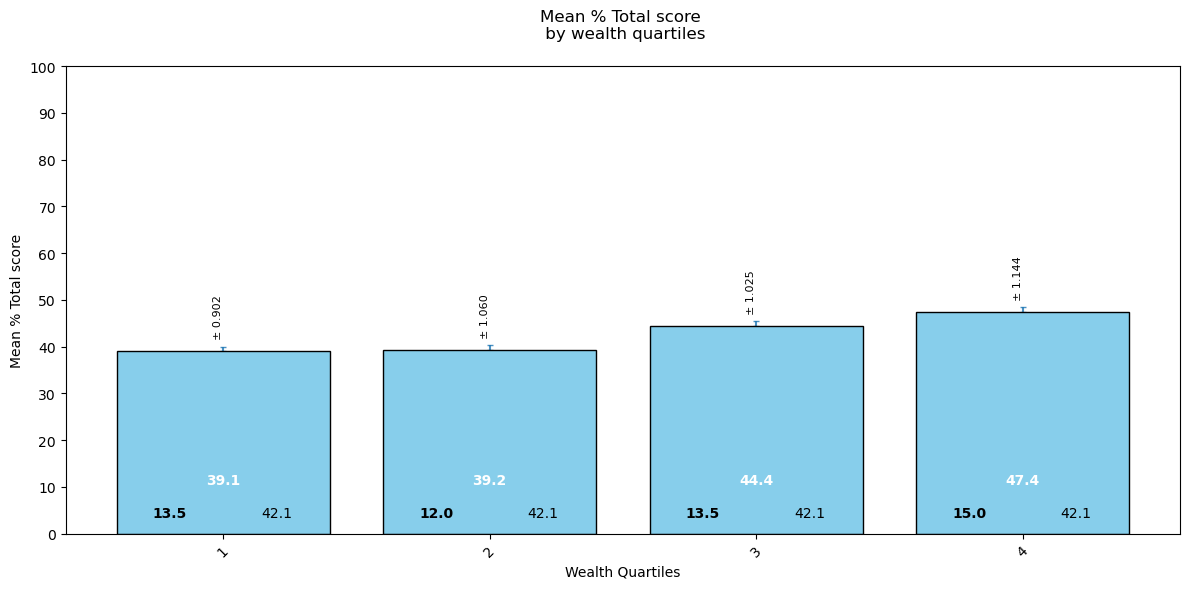

In [41]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

mean_scores = sample.groupby("wealth_quartile")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(1, 5, step = 1))

axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Wealth Quartiles")

plt.tight_layout()
plt.show()


---

## Table 2.2 - Per wealth class: Mean Facet Scores

In [42]:
income_classes

array([1, 2, 3, 4, 5, 6])

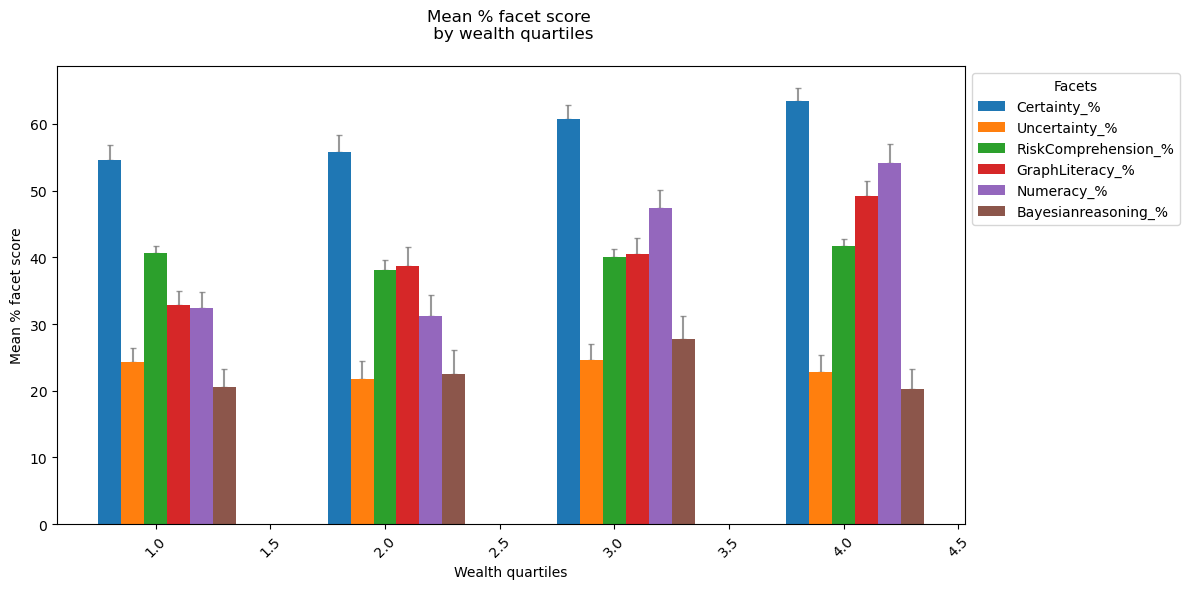

In [43]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = np.array(sorted(wealth_filtered["wealth_quartile"].unique()))

mean_scores = sample.groupby("wealth_quartile")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(wealth_quartiles)/ 2 + j) * width
    axes.bar(wealth_quartiles + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(wealth_quartiles + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % facet score")
axes.set_xlabel("Wealth quartiles")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

## Table 5.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [44]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [45]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

risklit_quartile = pd.qcut(wealth_filtered["TotalScore_19"],q = 4, labels = False ) + 1
wealth_filtered["risklit_quartile"] = risklit_quartile.copy()

data = wealth_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [46]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "wealth_quartile")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Wealth quartiles", bbox_to_anchor=(1, 1))
    
# plt.show()

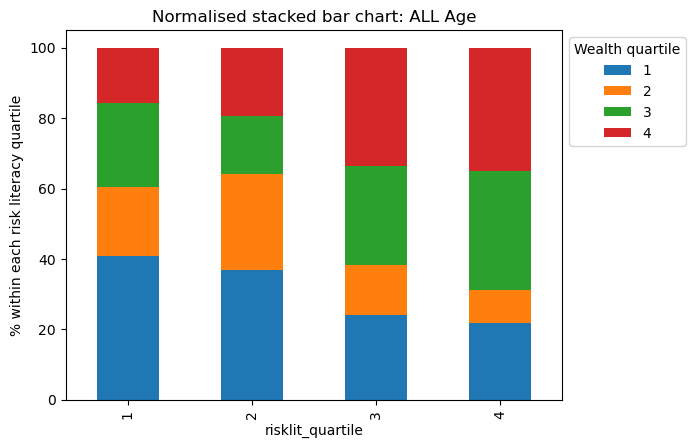

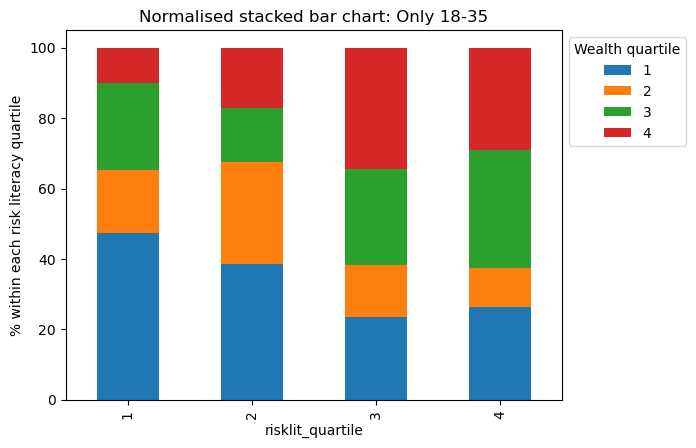

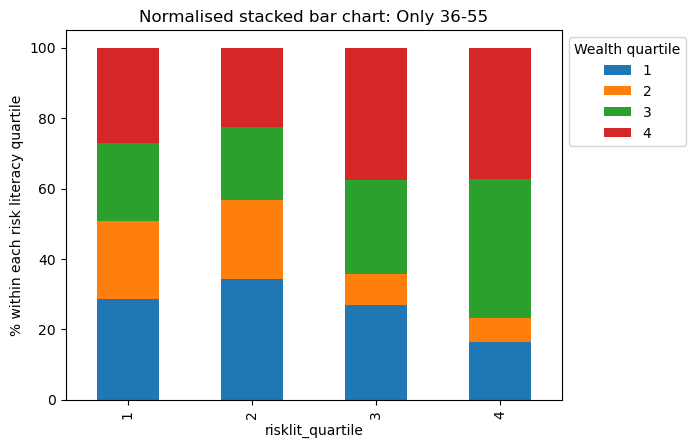

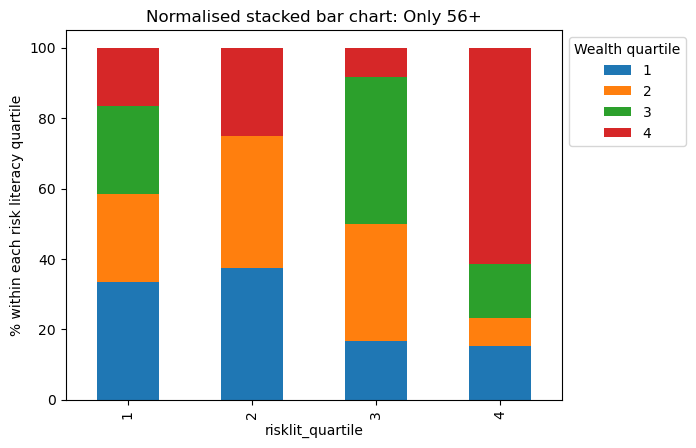

In [47]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "wealth_quartile")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Wealth quartile", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

In [74]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.049694
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -733.74
Model:                   OrderedModel   AIC:                             1473.
Method:            Maximum Likelihood   BIC:                             1487.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:47:24                                         
No. Observations:                 699                                         
Df Residuals:                     696                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Income Class depending on Risk literacy without, and with control of education, and with education and age

### V1: Without any control variables

In [49]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.617684
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1130.8
Model:                   OrderedModel   AIC:                             2274.
Method:            Maximum Likelihood   BIC:                             2301.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:00                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [75]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.991388
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -692.98
Model:                   OrderedModel   AIC:                             1394.
Method:            Maximum Likelihood   BIC:                             1412.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:07:51                                         
No. Observations:                 699                                         
Df Residuals:                     695                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [76]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.991374
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -692.97
Model:                   OrderedModel   AIC:                             1396.
Method:            Maximum Likelihood   BIC:                             1419.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:08:01                                         
No. Observations:                 699                                         
Df Residuals:                     694                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [52]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.545540
         Iterations: 31
         Function evaluations: 37
         Gradient evaluations: 37
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -1080.3
Model:                   OrderedModel   AIC:                             2179.
Method:            Maximum Likelihood   BIC:                             2220.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 699                                         
Df Residuals:                     690                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Income Class depending on Risk literacy without, and under control of education, FOR 36-55 years old, where we can assume skill-related variance

### V1: without control of education

In [77]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.035575
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -237.15
Model:                   OrderedModel   AIC:                             480.3
Method:            Maximum Likelihood   BIC:                             490.6
Date:                Tue, 24 Jun 2025                                         
Time:                        15:08:30                                         
No. Observations:                 229                                         
Df Residuals:                     226                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [54]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.605316
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -367.62
Model:                   OrderedModel   AIC:                             749.2
Method:            Maximum Likelihood   BIC:                             773.3
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 229                                         
Df Residuals:                     222                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [55]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.574854
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -360.64
Model:                   OrderedModel   AIC:                             737.3
Method:            Maximum Likelihood   BIC:                             764.8
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 229                                         
Df Residuals:                     221                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Wealth Quartiles depending on Risk literacy without, and with control of education, and with education and age

### V1: Without any control variables

In [56]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.339855
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -936.56
Model:                   OrderedModel   AIC:                             1881.
Method:            Maximum Likelihood   BIC:                             1899.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 699                                         
Df Residuals:                     695                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [57]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.305237
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -912.36
Model:                   OrderedModel   AIC:                             1835.
Method:            Maximum Likelihood   BIC:                             1857.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 699                                         
Df Residuals:                     694                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [58]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.298779
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -907.85
Model:                   OrderedModel   AIC:                             1828.
Method:            Maximum Likelihood   BIC:                             1855.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 699                                         
Df Residuals:                     693                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education, age and Financial Lit

In [59]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.286741
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -899.43
Model:                   OrderedModel   AIC:                             1813.
Method:            Maximum Likelihood   BIC:                             1845.
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:01                                         
No. Observations:                 699                                         
Df Residuals:                     692                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Wealth Quartiles depending on Risk literacy without, and under control of education, FOR 36-55 years old, where we can assume skill-related variance

### V1: without control of education

In [60]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.348215
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -308.74
Model:                   OrderedModel   AIC:                             625.5
Method:            Maximum Likelihood   BIC:                             639.2
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:02                                         
No. Observations:                 229                                         
Df Residuals:                     225                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V1: with control of education

In [61]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.288747
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -295.12
Model:                   OrderedModel   AIC:                             600.2
Method:            Maximum Likelihood   BIC:                             617.4
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:02                                         
No. Observations:                 229                                         
Df Residuals:                     224                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education and financial literacy

In [62]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.273174
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -291.56
Model:                   OrderedModel   AIC:                             595.1
Method:            Maximum Likelihood   BIC:                             615.7
Date:                Tue, 24 Jun 2025                                         
Time:                        14:46:02                                         
No. Observations:                 229                                         
Df Residuals:                     223                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Willingness to take risk vs risk literacy

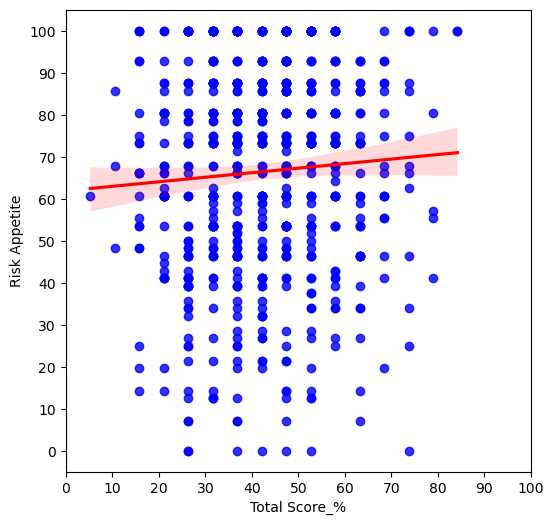

In [63]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = (main["RiskAppetite1_%"] + main["RiskAppetite2_%"])/2, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risk Appetite', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Habits vs risk literacy

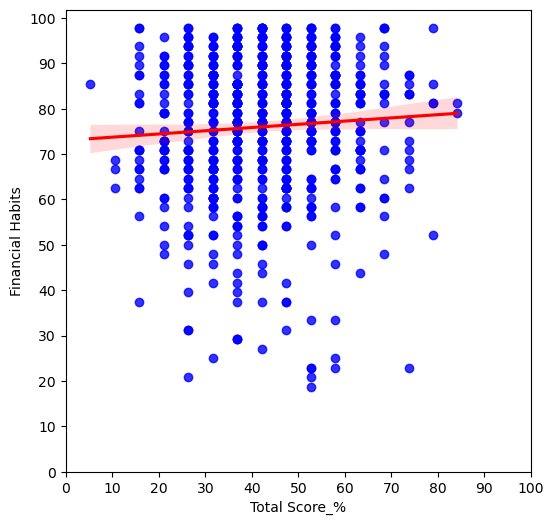

In [64]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialHabits_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Habits', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Risky Assets ownership vs risk literacy

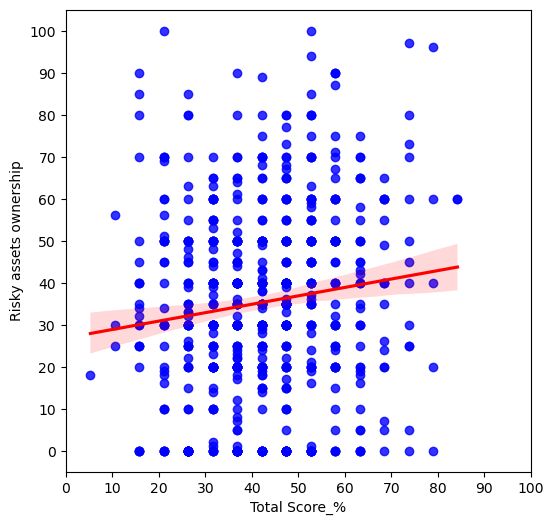

In [65]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["RiskAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risky assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Safe Assets ownership vs risk literacy

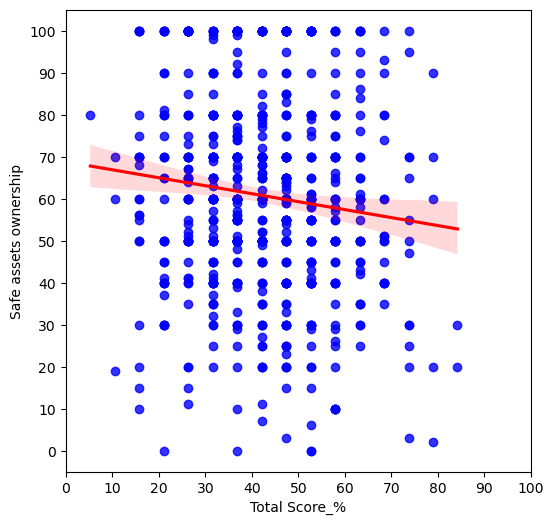

In [66]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["SafeAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Safe assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Literacy vs risk literacy

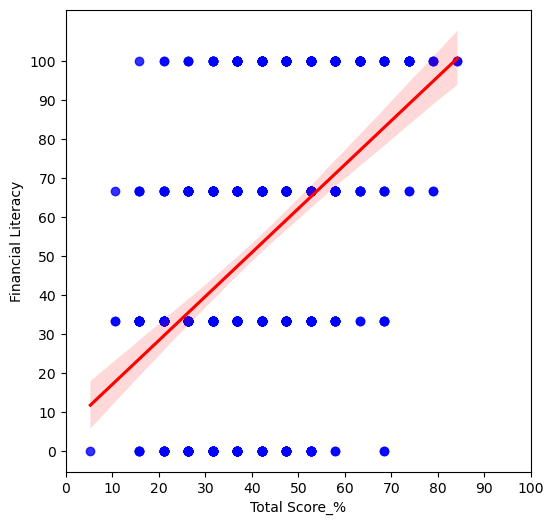

In [67]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialLiteracy_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Literacy', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

In [68]:
699 * 0.333

232.76700000000002

In [69]:
main["income"].value_counts().sort_index()

income
1    194
2    221
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [70]:
main["income"].value_counts().sort_index() / 699 * 100

income
1    27.753934
2    31.616595
3    16.309013
4    10.872675
5     7.439199
6     6.008584
Name: count, dtype: float64

In [71]:
main["income"].count()

699

In [72]:
# income_terciles
1 - income = 1 --> 194 (194)
2 - income = 2 3 --> 335 (114 + 221)
3 - income = 4 5 6 --> 170 (76 + 52 + 42)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3818069509.py, line 2)

How to Form Terciles from Categorical Data
If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
5. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.